# GEE TOOLS
## 6 - Mapa de iluminación
Extrae los datos del archivo de resultados de mapas de iluminación de EnergyPlus&reg;. Este notebook contiene inicialmente el código a implementar para leer estos archivos, después se utilizará para mostrar su funcionamiento con ejemplos.

In [35]:
import pandas as pd
from datetime import datetime
import seaborn as sbn
import matplotlib.pyplot as plt

## 6.1 - Clase IlluMap
Con la que se recopilará la información del archivo de salida de EnergyPlus, se organizará por nombre de mapa de iluminación, y cada uno tendrá los dataframe en un diccionario con fechas como llave.
PENDIENTE:
- Función para construir dataframe con promedios de los datos recopilados (debe tener un argumento para definir si se toma mensual, trimestral, semestral, anual o por un rango definido)

In [12]:
class IlluMap():
    """
    A class to capture and process all data of an EnergyPlus illumination map output
    
    This class allows to evaluate the illumination map results by reading the output file of EnergyPlus, saving
    all data in a class for each illumination map output and returns average by month, year or a specified range
    of date in a dataframe of pandas.
    
    
    Arguments:
      
    Properties:
      * thermal_zone
      * name
      * reference_points
      * data
    """
    __slots__ = ("_thermal_zone", "_name", "_reference_points", "_data")
    
    def __init__(self,
                 tz:str="Thermal Zone",
                 name:str="Illumination Map",
                 refpoints:float=(0.,0.,0.)):
        self._thermal_zone = tz
        self._name = name
        self._reference_points = refpoints
        self._data = {}
    
    @property
    def thermal_zone(self)->str:
        """Returns thermal zone of illumination map"""
        return self._thermal_zone
    
    @thermal_zone.setter
    def thermal_zone(self, tz:str):
        """Defines thermal_zone"""
        self._thermal_zone = tz
        
    @property
    def name(self) -> str:
        """Returns name of illumination map"""
        return self._name
    
    @name.setter
    def name(self, nm:str):
        """Defines illumination map name"""
        self._name = nm
        
    @property
    def reference_points(self)->float:
        """Returns reference points of illumination map"""
        return self._reference_points
    
    @reference_points.setter
    def reference_points(self, refpoints:float):
        """Defines reference points with origin of illumination map"""
        self._reference_points = refpoints
    
    @classmethod
    def _is_date(cls, text:str, date_format:str=" %m/%d %H:%M")->bool:
        try:
            datetime.strptime(text, date_format)
            return True
        except:
            return False
    
    @classmethod
    def _get_info(cls, text:str)->tuple:
        name = text.split(',')[1].split(':')[2].split(" at ")[0]
        tz = text.split(',')[1].split(':')[0]
        RefPts = [float(x) for x in text.split(',')[2].split('(')[1].split(')')[0].split(':')]
        return name, tz, RefPts 
        
    @classmethod
    def get_illumaps_from_file(cls, file_name = "eplusmap.csv", date_format = " %m/%d %H:%M", year=2000)->list:
        """Creates a list with IllumMap instances of a file with illumination map info in EnergyPlus format"""
        with open(file_name, "r") as file:
            illum_map = file.read().splitlines()
        illumaps = []
        names = []
        initial = True
        for i in range(len(illum_map)):
            X_value = illum_map[i].split(',')[0]
            if (X_value == "Date/Time"):
                info = cls._get_info(illum_map[i])
                if (info[0] not in names):
                    names.append(info[0])
                    illumaps.append(IlluMap(name=info[0], tz=info[1], refpoints=info[2]))
                index = names.index(info[0])
            elif cls._is_date(X_value): 
                if not initial: 
                    illudata.index = Y_array
                    illudata_t = illudata.transpose()
                    illudata_t.index.names = ["Coordinates"]
                    illumaps[index].add_data(illudata_t, timestamp)
                else:
                    initial = False
                illudata = pd.DataFrame()
                timestamp = datetime.strptime(X_value,' %m/%d %H:%M').replace(year=year)
                Y_array = [y[:-1] for y in illum_map[i].split(',')[1:]]
            else:
                illudata[X_value[:-1]] = [float(x) for x in illum_map[i].split(',')[1:]]
        return illumaps
    
    def add_data(self, data:pd.DataFrame, timestamp:datetime)->bool:
        """Adds a new data collection of illumination for a specified datetime"""
        self._data[timestamp] = data
        return True
    
    def data_at(self, timestamp:datetime)->pd.DataFrame:
        """Returns dataframe for a specified datetime"""
        return self._data[timestamp]
    
    def data_at(self,
                year:int=None,
                month:int=None,
                day:int=None,
                hour:int=None,
                minute:int=None,
                mode:str="mean")->pd.DataFrame:
        """
        Returns the dataframe with illumination map based on the date, if a value is not delivered it will return
        a unique data with the mean, max, or min of all dataframes that coincides with the datetime 
        """
        return self._data[datetime(year,month,day,hour,minute)]
    
    def get_datetimes(self) -> list:
        """Returns a list with all timestamp keys with illumination map data"""
        return list(self._data.keys())

Pruebas de lectura de archivo.

PENDIENTE: Pruebas con archivo con múltiples mapas de iluminación

In [13]:
IlluMaps = IlluMap.get_illumaps_from_file(file_name = "../data/eplusmap.csv")

In [14]:
IlluMaps[0].data_at(2000,11,5,8,0)

,(-2.28E-015;9.95E-016),(0.29;0.42),(0.57;0.85),(0.86;1.27),(1.15;1.70),(1.43;2.12),(1.72;2.55),(2.00;2.97),(2.29;3.40),(2.58;3.82),(2.86;4.25),(3.15;4.67),(3.44;5.09),(3.72;5.52),(4.01;5.94),(4.30;6.37),(4.58;6.79),(4.87;7.22),(5.15;7.64),(5.44;8.07)
Coordinates,,,,,,,,,,,,,,,,,,,,
(-2.28E-015;9.95E-016),559.0,2242.0,2240.0,2240.0,2236.0,2637.0,2862.0,2875.0,2862.0,2845.0,2815.0,2736.0,2733.0,2817.0,2849.0,2873.0,2876.0,2874.0,2813.0,559.0
(-0.40;0.27),559.0,3353.0,3386.0,3307.0,3244.0,2247.0,2559.0,2613.0,2573.0,1945.0,2219.0,2496.0,2528.0,2577.0,2451.0,2479.0,2680.0,2642.0,2279.0,559.0
(-0.79;0.53),559.0,3143.0,3283.0,3263.0,1645.0,2158.0,2339.0,2396.0,2335.0,1976.0,2157.0,2326.0,2398.0,2417.0,2320.0,2433.0,2417.0,2297.0,1815.0,559.0
(-1.19;0.80),559.0,3014.0,3151.0,3235.0,1863.0,2015.0,2117.0,2173.0,2084.0,1964.0,2034.0,2169.0,2215.0,2212.0,2213.0,2224.0,2179.0,2002.0,1565.0,559.0
(-1.58;1.07),559.0,2964.0,3133.0,3128.0,1740.0,1873.0,1918.0,1948.0,1857.0,1793.0,1925.0,1968.0,1988.0,2029.0,2056.0,1986.0,1932.0,1769.0,1411.0,559.0
(-1.98;1.33),559.0,2929.0,3027.0,3252.0,1661.0,1744.0,1769.0,1746.0,1757.0,1761.0,1798.0,1798.0,1818.0,1867.0,1925.0,1839.0,1706.0,1544.0,1288.0,559.0
(-2.37;1.60),559.0,2881.0,2967.0,3142.0,1545.0,1637.0,1632.0,1639.0,1692.0,1710.0,1667.0,1699.0,1761.0,1778.0,1771.0,1714.0,1609.0,1397.0,1181.0,559.0
(-2.77;1.87),559.0,2808.0,2984.0,3118.0,1561.0,1572.0,1580.0,1643.0,1637.0,1599.0,1671.0,1679.0,1697.0,1694.0,1600.0,1581.0,1474.0,1281.0,1120.0,559.0
(-3.16;2.13),559.0,2784.0,2948.0,1321.0,1462.0,1493.0,1498.0,1508.0,1498.0,1542.0,1567.0,1579.0,1582.0,1460.0,1439.0,1454.0,1352.0,1201.0,1033.0,559.0


## 6.2 - Función promedio de dataframes
Pruebas para función que llamará los dataframe de un periodo de tiempo de la clase IlluMap y generará un único dataframe con los promedios para cada coordenada

In [15]:
# Arguments
year = None
month = None
day = None
hour = None
minute = None
mode = "mean"

In [16]:
year = 2000

In [26]:
12 == hour

False

In [17]:
datetime_keys = IlluMaps[0].get_datetimes()

In [28]:
combined_data = pd.DataFrame()
for dt in datetime_keys:
    if (year is None):
        pass # Se debería lanzar un error
    elif (month is None):
        if (dt.year == year): 
            combined_data = pd.concat([combined_data, IlluMaps[0].data_at(dt.year, dt.month, dt.day, dt.hour, dt.minute)])
        else:
            pass
            #return pd.DataFrame() #Entregar dataframe desocupado o se podría lanzar un error
    elif (day is None):
        if (dt.year == year and dt.month == month):
            combined_data = pd.concat([combined_data, IlluMaps[0].data_at(dt.year, dt.month, dt.day, dt.hour, dt.minute)])
        else:
            pass
            #return pd.DataFrame() # Entregar dataframe desocupado o se podría lanzar un error
    elif (hour is None):
        if (dt.year == year and dt.month == month and dt.day == day):
            combined_data = pd.concat([combined_data, IlluMaps[0].data_at(dt.year, dt.month, dt.day, dt.hour, dt.minute)])
        else:
            pass
            #return pd.DataFrame() # Entregar dataframe desocupado o se podría lanzar un error
    elif (minute is None):
        if (dt.year == year and dt.month == month and dt.day == day and dt.hour == hour):
            combined_data = pd.concat([combined_data, IlluMaps[0].data_at(dt.year, dt.month, dt.day, dt.hour, dt.minute)])
        else:
            pass
            #return pd.DataFrame() # Entregar dataframe desocupado o se podría lanzar un error
    else:
        pass
        #return IlluMaps[0].data_at(dt.year, dt.month, dt.day, dt.hour, dt.minute)

In [29]:
mean_data = combined_data.groupby("Coordinates", sort=False).mean()

In [30]:
mean_data

,(-2.28E-015;9.95E-016),(0.29;0.42),(0.57;0.85),(0.86;1.27),(1.15;1.70),(1.43;2.12),(1.72;2.55),(2.00;2.97),(2.29;3.40),(2.58;3.82),(2.86;4.25),(3.15;4.67),(3.44;5.09),(3.72;5.52),(4.01;5.94),(4.30;6.37),(4.58;6.79),(4.87;7.22),(5.15;7.64),(5.44;8.07)
Coordinates,,,,,,,,,,,,,,,,,,,,
(-2.28E-015;9.95E-016),667.153395,7907.281224,7817.382439,7060.191115,5803.348701,4173.502934,4586.053227,4491.238055,4366.763621,4298.900671,4233.357083,4163.819992,4136.286672,4193.576697,4242.578164,4321.580260,4326.234912,4356.260268,4346.560981,667.153395
(-0.40;0.27),667.153395,7507.844510,7943.227787,7693.315381,6902.689229,5441.435247,4249.097234,3751.972129,3696.856035,2951.187972,2947.410101,3444.317058,3493.027661,3526.053018,3469.697821,3564.276823,3734.157586,3693.821459,3091.377200,667.153395
(-0.79;0.53),667.153395,5627.814124,6969.209975,6732.142707,6158.995809,5133.359388,3934.645641,3585.097863,3213.715842,2851.498533,2870.406329,3059.686505,3152.925398,3170.634954,3127.152557,3222.821878,3090.444258,2866.575231,2330.930637,667.153395
(-1.19;0.80),667.153395,4343.505239,5025.243923,5275.692582,5027.496647,4235.839690,3374.265088,3101.796102,2705.387049,2632.034158,2569.601215,2694.727787,2750.531014,2727.567687,2749.276194,2725.376991,2568.999790,2330.091995,1943.843881,667.153395
(-1.58;1.07),667.153395,3250.923512,3947.266345,4263.567896,4247.333403,3708.077955,3062.788768,2641.427913,2412.212699,2246.696982,2307.650671,2326.566010,2335.766974,2345.981559,2384.350587,2263.809933,2121.484493,1962.385792,1704.240360,667.153395
(-1.98;1.33),667.153395,2671.325231,3757.690696,3790.629086,3243.030805,2963.704526,2482.512783,1926.910729,2048.740989,2060.916178,2056.595977,2031.658843,2044.479044,2064.024937,2079.499162,1960.667435,1795.424769,1645.264878,1508.054065,667.153395
(-2.37;1.60),667.153395,2240.443210,2982.138307,3044.468986,2840.781643,2472.265507,1970.209137,1923.399413,1801.423093,1865.394384,1836.644803,1823.142498,1876.528919,1857.878458,1830.839480,1732.431475,1652.924769,1456.742456,1340.542959,667.153395
(-2.77;1.87),667.153395,1826.181056,2094.265507,2580.467309,2408.807209,1939.100168,1669.238684,1630.377200,1692.000838,1686.929799,1704.100587,1729.073554,1706.282062,1680.646899,1632.615884,1539.240151,1475.723596,1323.947192,1253.487846,667.153395
(-3.16;2.13),667.153395,1792.657586,2349.572716,2321.409472,1982.760897,1732.959556,1591.875733,1548.989313,1495.597443,1565.513202,1560.535624,1557.425817,1563.288558,1468.529338,1467.692791,1400.785624,1345.399832,1235.906957,1136.772842,667.153395


In [31]:
max_data = combined_data.groupby("Coordinates", sort=False).max()

## 6.3 - Ploteo de resultados
Contenido que va a tener el notebook final de este 

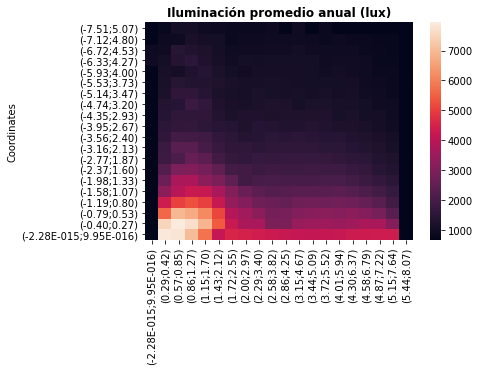

In [62]:
fig, ax = plt.subplots()
sbn.heatmap(mean_data, cmap="rocket").invert_yaxis()
plt.title("Iluminación promedio anual (lux)", fontsize=12, fontweight="bold")
plt.savefig("illumap.svg", format="svg")